# Additive Synthesis

Here we build on our sinusoidal oscillator by summing multiple instances of them together
to start to model more complex audio signals. This is known as **additive synthesis**. We first introduce the most general form
of an additive synthesizer, which is unconstrained (i.e. each sinusoidal component can take any frequency or amplitude). After, we'll
add constraints to this algorithm which will add an inductive bias towards the generation
of desired signal components, such as harmonic signals.

## Unconstrained Additive Synthesis

Motivated by the signal processing interpretation of Fourier's theorem, i.e. that a signal can be decomposed into sinusoidal components, additive synthesis describes a signal as a finite sum of sinusoidal components. Unlike representation in the discrete Fourier basis, however, the frequency axis is not necessarily discretised, allowing for direct specification of component frequencies.
The general form for such a model in discrete time is thus:

$$
    y[n] = \sum_{k}^{K}\alpha_k[n]\sin\left(\phi_k + \sum_{m=0}^{n}\omega_k[m]\right)
$$

where $K$ is the number of sinusoidal components, $\mathbf{\alpha}[n]\in\mathbb{R}^K$ is a time series of component amplitudes, $\mathbf{\phi}\in\mathbb{R}^K$ is the component-wise initial phase, and $\mathbf{\omega}[n]$ is the time series of instantaneous component frequencies.

In [1]:
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.animation import FuncAnimation

# Random Seed
_ = torch.random.manual_seed(0)

In [2]:
def additive_synth(
    amplitudes: torch.Tensor,  # Amplitudes
    frequencies: torch.Tensor,  # Angular frequencies (rad / sample)
):
    assert (
        frequencies.ndim == 3
    ), "Frequencies must be 3D (batch, n_frequencies, n_samples)"
    assert (
        frequencies.shape == amplitudes.shape
    ), "Frequency and amplitude shapes must match"

    # Set initial phase to zero, prepend to frequency envelope
    initial_phase = torch.zeros_like(frequencies[:, :, :1])
    frequencies = torch.cat([initial_phase, frequencies], dim=-1)

    # Create the phase track and remove the last sample (since we added initial phase)
    phase = torch.cumsum(frequencies, dim=-1)[..., :-1]
    y = torch.sin(phase) * amplitudes
    y = torch.sum(y, dim=1)
    return y

### Using our additive synthesizer

Let's create some toy frequency and amplitude envelopes to pass into our additive
synthesizer.

In the next notebook we'll look at how we can create envelopes to match instrumental
sounds. For now, to see how this synthesizer works, let's create simple envelopes that start from a random frequency,
converge to a center frequency, and then diverge back to the random frequency.

In [3]:
num_components = 8
frequencies = torch.rand(num_components) * 500 + 200
print(frequencies)

tensor([448.1283, 584.1109, 244.2387, 266.0153, 353.7114, 517.0393, 445.0467,
        648.2224])


In [4]:
sample_rate = 16000
target_frequency = 440

# Create a frequency envelope that sweeps from the initial frequency to the target frequency
frequency_envelopes = []
for freq in frequencies:
    f_env = torch.linspace(freq, target_frequency, sample_rate).unsqueeze(0)
    frequency_envelopes.append(f_env)

# Stack all the frequency envelopes together
frequency_envelopes = torch.cat(frequency_envelopes, dim=0).unsqueeze(0)

# Reverse the frequency envelope and append it to itself - this creates a converging and diverging frequency envelope
frequency_envelopes = torch.cat(
    [frequency_envelopes, frequency_envelopes.flip(-1)], dim=-1
)

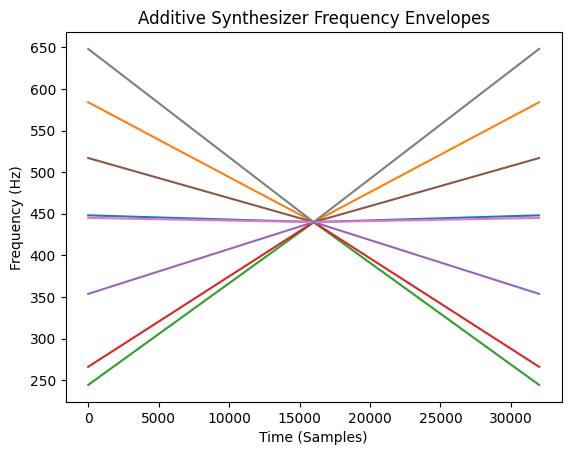

In [5]:
for i in range(frequency_envelopes.shape[1]):
    plt.plot(frequency_envelopes[0, i])

plt.title("Additive Synthesizer Frequency Envelopes")
plt.xlabel("Time (Samples)")
plt.ylabel("Frequency (Hz)")
plt.show()

Convert the frequency in Hz to angular frequency, create a static amplitude envelope
for each sinusoidal component, and listen to the result.

In [6]:
# Convert to rad / sample
omegas = 2 * torch.pi * frequency_envelopes / sample_rate

# Amplitude envelopes so each frequency has the same amplitude
amplitudes = torch.ones(1, omegas.shape[1], omegas.shape[-1])

# Synthesize the audio
y = additive_synth(amplitudes, omegas)

ipd.Audio(y[0].numpy(), rate=sample_rate)

## Constrained Additive Synthesis

Additive synthesis is powerful and in theory can be used to synthesize any sound. However, 
for some problems we don't need to be able to generate any sound. We can use acoustic knowledge
of our target domain to constrain the space of possible solutions. 
Constraining our synthesizer adds an inductive bias towards the generation of certain classes of sounds.
In the context of a machine learning problem, this means that we've constrained the size of our solution
space and can potentially solve 
our problem more efficiently, with smaller models and less data.

For instance, many musical instruments are harmonic, meaning
that the sinusoidal components are at frequencies that are integer multiples of the fundamental
frequency. We can embed this knowledege into our synthesizer.

Harmonically constrained synthesis was used in Engel et al.'s DDSP work [1] and has been the
focus of many subsequent DDSP synthesis works.

## Harmonic Synthesizer

We updated the general form for additive synthesis for harmonic synthesis:

$$
y[n] = \sum_{k=1}^{K}\alpha_k[n]\sin\left(\phi_{k} + k\sum_{m=0}^{n}\omega_{0}[m]\right)
$$

where $K$ is the number of harmonics, $\omega_0$ is the time-varying fundamental frequency,
and $\alpha_k$ is the time-varying amplitude for the $k^{\text{th}}$ harmonic. $\phi_k$ is
the initial phase of the $k^{\text{th}}$ harmonic, although in practice this is often
set to zero.

### Implementing a harmonic synthesizer

To constrain our additive synthesizer we'll first introduce a function that receives
a time-varying fundamental frequency envelope and returns a tensor of frequencies
with $K$ harmonics that are harmonically related to the fundamental.

In [7]:
def get_harmonic_frequencies(
    f0: torch.Tensor,  # Fundamental frequency (Hz) (batch, n_samples)
    num_harmonics: int,  # Number of harmonics to generate
):
    # Create integer harmonic ratios and reshape to (1, n_harmonics, 1) so we can
    # multiply with fundamental frequency tensor repeated for num_harmonics
    harmonic_ratios = torch.arange(1, num_harmonics + 1).view(1, -1, 1)

    # Duplicate the fundamental frequency for each harmonic
    frequencies = f0.unsqueeze(1).repeat(1, num_harmonics, 1)

    # Multiply the fundamental frequency by the harmonic ratios
    frequencies = frequencies * harmonic_ratios

    return frequencies

Next, we'll define a harmonic synthesizer function that receives a fundamental frequency
envelope and a set of time-varying amplitudes for $K$ harmonics. Using our function `get_harmonic_frequencies`
we'll generate the harmonic frequency envelopes and pass these along with the amplitudes
to `additive_synth`.

In [8]:
def harmonic_synth(
    f0: torch.Tensor,  # Fundamental frequency (Hz) (batch, n_samples)
    harmonic_amps: torch.Tensor,  # Amplitudes of harmonics (batch, n_harmonics, n_samples)
):
    assert f0.ndim == 2, "Fundamental frequency must be 2D (batch, n_samples)"
    assert (
        harmonic_amps.ndim == 3
    ), "Harmonic amplitudes must be 3D (batch, n_harmonics, n_samples)"

    # Create the harmonic frequency envelopes
    num_harmonics = harmonic_amps.shape[1]
    frequencies = get_harmonic_frequencies(f0, num_harmonics)

    return additive_synth(harmonic_amps, frequencies)

### Using our harmonic synthesizer

Here, we demonstrate our harmonic synthesizer by generating random distributions of
harmonics. To turn harmonics into a distribution we'll further constrain the amplitudes
of each harmonic to sum to one: $\sum_{k=0}^{K}c_k = 1$ where $c_k$ is the $k^{\text{th}}$
harmonic amplitude.

This means that the output of our synthesizer will have a unity gain regardless of the
distribution of the underlying harmonics. In the next section we will introduce a global
amplitude control to vary the loudness of our signal. In practice, constraining the harmonics
to sum to one will make it easier for the optimizer to learn the global amplitude envelope.

In [9]:
def random_harmonic_amps(
    batch_size: int,  # Number of samples to generate
    num_harmonics: int,  # Number of harmonics to generate
    num_samples: int,  # Number of samples in length
):
    # Create random amplitudes for each harmonic (but set the first harmonic to 1)
    harmonic_amps = torch.rand(batch_size, num_harmonics) * 40.0 - 40.0
    harmonic_amps = torch.pow(10, harmonic_amps / 20.0)

    # Turn harmonic amplitudes into a distribution
    harmonic_amps = harmonic_amps / harmonic_amps.sum(dim=1, keepdim=True)

    # Turn the harmonic amplitudes into a tensor of time-varying amplitudes
    harmonic_amps = torch.ones(1, num_harmonics, num_samples) * harmonic_amps.view(
        1, -1, 1
    )

    return harmonic_amps

### Musical Expression: Vibrato

Instead of creating a static fundamental frequency,
let's add some **vibrato** to this signal. 

Vibrato is a musical effect where the pitch of note
is subtly adjusted in an oscillating way around the main frequency. We can model vibrato
by modulating our fundamental frequency with a slow sinusoidal signal.

In [10]:
f0 = 110  # Fundamental frequency (Hz)

vibrato_rate = 5.0  # Rate of vibrato (Hz)
vibrato_depth = 0.75  # Depth of vibrato (Hz)

# Create a sinusoid at the vibrato rate
vibrato = torch.ones(1, sample_rate) * vibrato_rate
vibrato = 2 * torch.pi * vibrato / sample_rate
vibrato = torch.sin(torch.cumsum(vibrato, dim=-1))

# Scale the vibrato to the desired depth
vibrato_depth = 2 * torch.pi * vibrato_depth / sample_rate
vibrato = vibrato * vibrato_depth

# Calculate the fundamental frequency in radians / sample
fundamental = 2 * torch.pi * f0 / sample_rate

# Scale the vibrato to the fundamental frequency
fundamental = fundamental + vibrato

Now if we look at our fundamental frequency envelope, we'll see it slowly oscillating
around the fundamental frequency.

It's a sinusoidal signal controlling a sinusoidal synthesizer!

Text(0.5, 1.0, 'Fundamental Frequency with Vibrato')

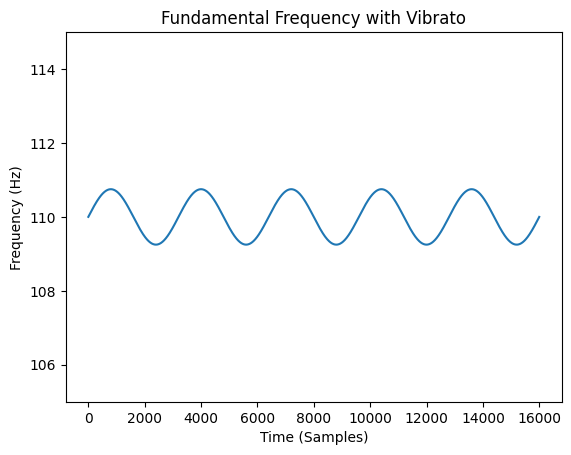

In [11]:
f0_hz = fundamental * sample_rate / (2 * torch.pi)
plt.plot(f0_hz[0])
plt.ylim(105, 115)
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (Samples)")
plt.title("Fundamental Frequency with Vibrato")

Let's listen to our harmonic synthesizer, controlled using our fundamental frequency with
added vibrato.

To see the effect of different distributions of harmonics, let's create a few different
random harmonic distributions and listen to them consecutively.

We can also see the different amplitudes of the harmonics in the different sections in the spectrogram below.

In [12]:
num_harmonics = 16  # Number of harmonics

y = []
for i in range(8):
    harmonic_amps = random_harmonic_amps(1, num_harmonics, sample_rate)
    y.append(harmonic_synth(fundamental, harmonic_amps))

y = torch.cat(y, dim=1)
ipd.Audio(y[0].numpy(), rate=sample_rate)

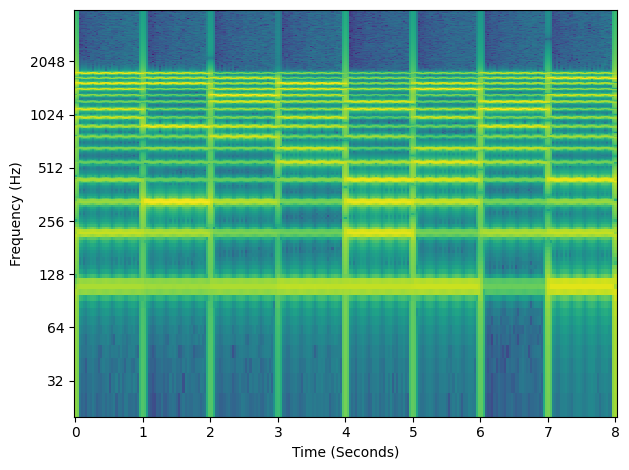

In [13]:
n_fft = 2048
hop_length = 512
X = torch.stft(
    y,
    n_fft=n_fft,
    hop_length=hop_length,
    return_complex=True,
    window=torch.hann_window(n_fft),
)

# Convert to decibels
X_mag = torch.abs(X)
X_db = 20.0 * torch.log10(X_mag + 1e-6)

# Get frequencies for each FFT bin in hertz
fft_freqs = torch.abs(torch.fft.fftfreq(2048, 1 / sample_rate)[: X_db.shape[1]])

# Time in seconds for each frame
times = torch.arange(X_db.shape[-1]) * hop_length / sample_rate

# Plot the spectrogram
fig, ax = plt.subplots()

ax.pcolormesh(times, fft_freqs, X_db[0].numpy())

# Set the y-axis to log scale
ax.set_yscale("symlog", base=2.0)
ax.set_ylim(20.0, 4000.0)

ax.yaxis.set_major_formatter(mplticker.ScalarFormatter())
ax.yaxis.set_label_text("Frequency (Hz)")

ax.xaxis.set_major_formatter(mplticker.ScalarFormatter())
ax.xaxis.set_label_text("Time (Seconds)")

plt.tight_layout()
plt.show()

Can you hear the **vibrato**? It's subtle, but it gives the signal a wavering singing-like quality.

How about the different **harmonic distributions**? The different harmonic distrbutions give each segment a different *timbral* qualilty ... they almost sound like different vowels being sung. 

In the next notebook we'll see how we can learn harmonic distributions to generate desired timbres of musical instruments!

## Further Constraints

Further constraints can be added to a harmonic synthesizer to generate desired signals.

Musical synthesizers, such as keyboard synthesizers or modular synths, typically have one or
more oscillators with a number of preset waveforms. **Sawtooth** and **square waves** are common
examples because they are harmonically rich and provide a good starting point for sound
shaping using filters. This type of synthesis is referred to as **subtractive synthesis** and
was the method used by popular Moog synthesizers. Learning parameters for these types of
musical synthesizers has been explored in a differentiable context by Masuda and Saito [2].

Sawtooth waveforms are also useful in speech and singing voice synthesis as an excitation
signal in a **source-filter** synthesis approach. For instance, Wu et al. used a differentiable sawtooth synthesizer
in SawSing [3].

Here we show how our harmonic synthesizer can be extended to approximate these two popular
waveforms. The animations show how adding more harmonics results in a closer approximation
to the true waveform shape.


## Sawtooth Waveform


$$
y_{\text{saw}}[n] = \sum_{k=1}^{K}\frac{2}{\pi{k}}\sin\left(k\sum_{m=0}^{n}\omega_0[m]\right)
$$

In [14]:
def sawtooth(
    num_harmonics: int,  # Number of harmonics to generate
    num_samples: int,  # Number of samples in length
):
    harmonics = torch.arange(1, num_harmonics + 1)
    harmonic_amps = 2.0 / (harmonics * torch.pi)

    # Turn the harmonic amplitudes into a tensor of time-varying amplitudes
    harmonic_amps = torch.ones(1, num_harmonics, num_samples) * harmonic_amps.view(
        1, -1, 1
    )

    return harmonic_amps

In [15]:
saw_amplitudes = sawtooth(16, sample_rate)
y = harmonic_synth(fundamental, saw_amplitudes)
ipd.Audio(y[0].numpy(), rate=sample_rate)

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
(line,) = ax.plot([], [], lw=2)
ax.set_ylim([-1.1, 1.1])
ax.set_xlim(0, 250)
ax.grid(True)


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    n = i + 1
    saw_amplitudes = sawtooth(n, sample_rate)
    y = harmonic_synth(fundamental, saw_amplitudes)
    line.set_data(torch.arange(250).numpy(), y[0].numpy()[:250])
    ax.set_title(f"Sawtooth Wave with N = {n} Harmonics")
    return (line,)


# Create the animation
anim = FuncAnimation(fig, animate, init_func=init, frames=24, interval=150, blit=True)
plt.close(fig)
# To display the animation in the Jupyter notebook:
display(ipd.HTML(anim.to_html5_video()))

## Square wave

$$
y_{\text{square}}[n] = \sum_{k=1}^{K}\frac{4}{\pi(2k -1)}\sin\left(2\pi(2k - 1)\sum_{m=0}^{n}\omega_0[m]\right)
$$

In [17]:
def square_wave(
    num_harmonics: int,  # Number of harmonics to generate
    num_samples: int,  # Number of samples in length
):
    harmonic_amps = torch.zeros(num_harmonics * 2)
    for i in range(1, len(harmonic_amps) + 1):
        if (i - 1) % 2 == 0:
            harmonic_amps[i - 1] = 4.0 / (torch.pi * i)

    # Turn the harmonic amplitudes into a tensor of time-varying amplitudes
    harmonic_amps = torch.ones(1, num_harmonics * 2, num_samples) * harmonic_amps.view(
        1, -1, 1
    )

    return harmonic_amps

In [18]:
square_amplitudes = square_wave(16, sample_rate)
y = harmonic_synth(fundamental, square_amplitudes)
ipd.Audio(y[0].numpy(), rate=sample_rate)

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))
(line,) = ax.plot([], [], lw=2)

max_amp = square_amplitudes.abs().max()
ax.set_ylim([-max_amp, max_amp])
ax.set_xlim(0, 250)
ax.grid(True)


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    n = i + 1
    square_amplitudes = square_wave(n, sample_rate)
    y = harmonic_synth(fundamental, square_amplitudes)
    line.set_data(torch.arange(250).numpy(), y[0].numpy()[:250])
    ax.set_title(f"Square Wave with N = {n} Harmonics")
    return (line,)


# Create the animation
anim = FuncAnimation(fig, animate, init_func=init, frames=24, interval=200, blit=True)
plt.close(fig)
# To display the animation in the Jupyter notebook:
display(ipd.HTML(anim.to_html5_video()))

## Summary

In this notebook we learned how to create an **additive synthesizer** by summing together multiple
different sinusoidal signals. These sinusoidal signals
can have frequency and amplitude envelopes with any value in an **unconstrained synthesizer**. 
A **harmonic synthesizer**, on the other hand, is an example of a **constrained additive synthesizer** where the frequencies of the sinsoidal components
are fixed to be integer multiples of a fundamental frequency. 
Many musical instrument sounds are
harmonic and imposing the harmonic constraint on our synthesizer will help us model these sounds, as
we'll see in the next notebook.
We concluded by looking at how we can further constrain the amplitudes in a harmonic synthesizer to
generate popular **sawtooth** and **square** waveforms.



## References

[1] Engel, Jesse, Chenjie Gu, and Adam Roberts. "DDSP: Differentiable Digital Signal Processing." International Conference on Learning Representations. 2019.

[2] Masuda, Naotake, and Daisuke Saito. "Improving Semi-Supervised Differentiable Synthesizer Sound Matching for Practical Applications." IEEE/ACM Transactions on Audio, Speech, and Language Processing 31 (2023): 863-875.

[3] Wu, Da-Yi, et al. "DDSP-based Singing Vocoders: A New Subtractive-based Synthesizer and A Comprehensive Evaluation." Ismir 2022 Hybrid Conference. 2022.